### Modelling memory distortions with a variational autoencoder: the Carmichael experiment

In an experiment by Carmichael et al. (1932), subjects were asked to reproduce ambiguous sketches. A context was established by telling the subjects that they would see images from a certain category. It was found that when the subjects tried to reproduce the image after a delay, their drawings were distorted to look more like members of the context class.

Nagy et al. (2020) showed that a variational autoencoder trained on a class biases recall towards that class, but they used a separate model for each class (rather than a single model with context as an input). The data below extends this by using a single model with the context represented by a cue in the image.

In this notebook, I train variational autoencoders on pairs of visually similar classes from the Quick Draw dataset. This is an open-source dataset of drawings by users of an online game (see https://github.com/googlecreativelab/quickdraw-dataset for details on the data). The results show that the model 'recalls' the same ambiguous image differently depending on the context; as in the Carmichael experiment, the 'recalled' image looks more like the context class.

This is based on the code at https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py

The image below shows a summary of results from the original (very old) paper.

![Screenshot 2021-02-11 at 13.27.57.png](attachment:Screenshot 2021-02-11 at 13.27.57.png)
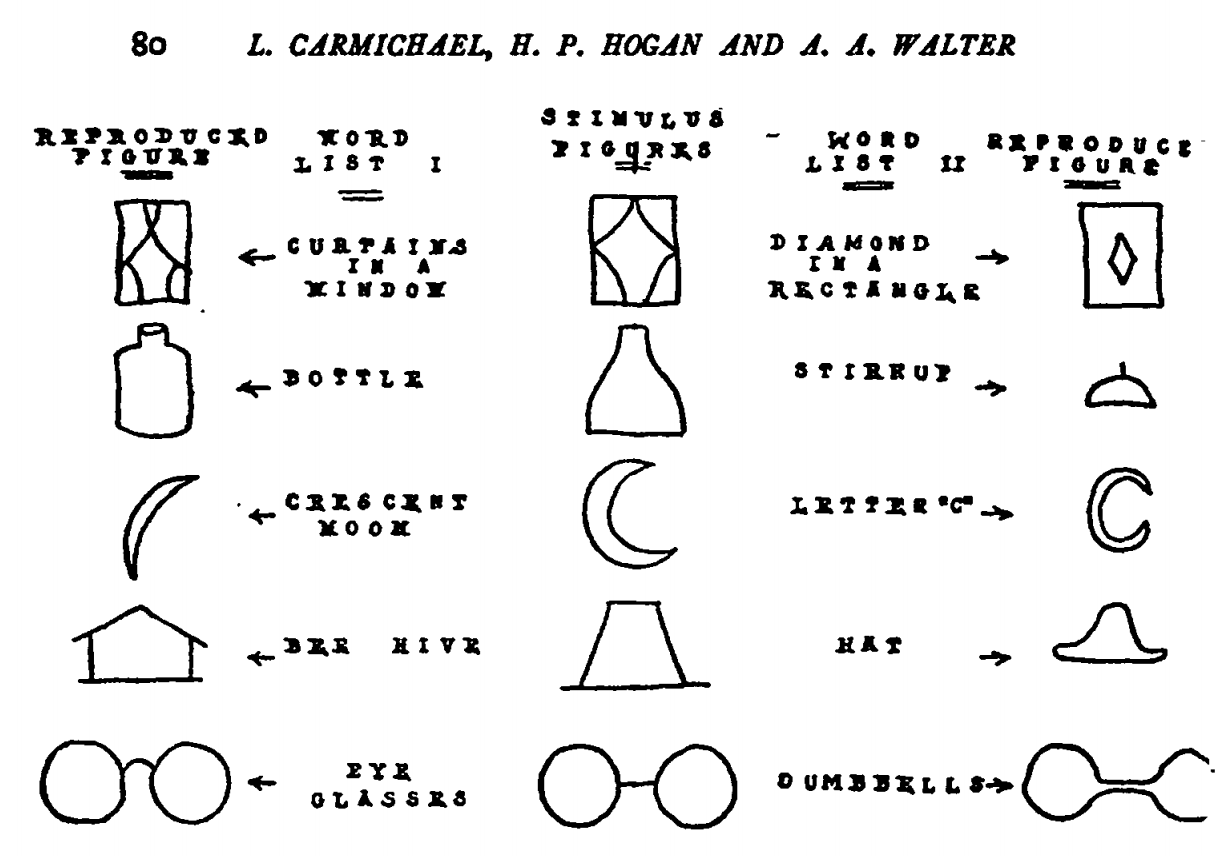

#### Installation and imports:

In [ ]:
!pip install tensorflow==2.2.0

In [112]:
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

#### Create a variational autoencoder for images

In [2]:
# Set the dimension of the latent space, i.e. number of latent variables
latent_dim = 2

## Create a sampling layer

class Sampling(layers.Layer):
    # Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the encoder
def build_models(latent_dim=2):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    # Both z_mean and z_log_var take the previous layer as the input
    # i.e. network branches into two vectors of size latent_dim=2
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    # This uses the special sampling layer defined above:
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    ## Build the decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return encoder, decoder

In [3]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            # Multiply reconstruction loss by number of pixels:
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


Define a function to plot the latent space:

In [5]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


#### Load the data

Based on Carmichael et al. (1932), let's pick two similar looking pairs of items:
* glasses and dumbbells
* bats and butterflies

In [9]:
data1 = np.load('full_numpy_bitmap_dumbbell.npy')
data2 = np.load('full_numpy_bitmap_eyeglasses.npy')
data3 = np.load('full_numpy_bitmap_bat.npy')
data4 = np.load('full_numpy_bitmap_butterfly.npy')

#### Add context cues

Equivalent to the use of a word to set the context in Carmichael et al, I add added a feature to each image that indicates the class. This will allow us to manipulate the context and see how that effects the reconstruction.

For the dumbbell-eyeglasses model, a horizontal line at the top of the image indicates the dumbbell class.
For the bat-butterfly model, this indicates the bat class.

In [10]:
def add_class_bar(d):
    d_bar = [255]*28 + list(d)[28:]
    return np.array(d_bar)

def remove_class_bar(d):
    d_bar = [0]*28 + list(d)[28:]
    return np.array(d_bar)

In [41]:
num = 20000
resized_train = [np.resize(add_class_bar(d), (28,28,1)) for d in data1][0:num] + [np.resize(d, (28,28,1)) for d in data2][0:num] #+ [np.resize(add_class_bar(d), (28,28,1)) for d in data3][0:num] + [np.resize(d, (28,28,1)) for d in data4][0:num]
train = np.stack(resized_train, axis=0).astype("float32") / 255

Plot an item from the dumbbells class as an example to see how the context appears:

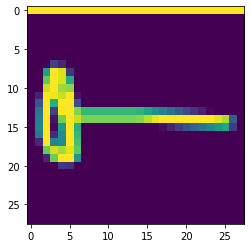

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(resized_train[0].reshape((28,28)))

#### Train the VAE

Using the functions defined above, build a VAE with two latent variables:

In [14]:
encoder, decoder = build_models(latent_dim=2)

What does the encoder look like?

In [15]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

What does the decoder look like?

In [16]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

Train the VAE:

In [17]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(train, epochs=30, batch_size=128, verbose=False)

#### Explore how context affects recall

Let's see how the model affects the same drawing with and without the context cue.

In [18]:
dumbbells_with_cue = [np.resize(add_class_bar(d), (28,28,1)) for d in data1[0:10]]
dumbbells_with_cue = np.array(dumbbells_with_cue).astype("float32") / 255
dumbbells_without_cue = [np.resize(d, (28,28,1)) for d in data1[0:10]]
dumbbells_without_cue = np.array(dumbbells_without_cue).astype("float32") / 255

glasses_with_cue = [np.resize(add_class_bar(d), (28,28,1)) for d in data2[0:10]]
glasses_with_cue = np.array(glasses_with_cue).astype("float32") / 255
glasses_without_cue = [np.resize(d, (28,28,1)) for d in data2[0:10]]
glasses_without_cue = np.array(glasses_without_cue).astype("float32") / 255

#### How does context affect recall of ambiguous items from the glasses category?

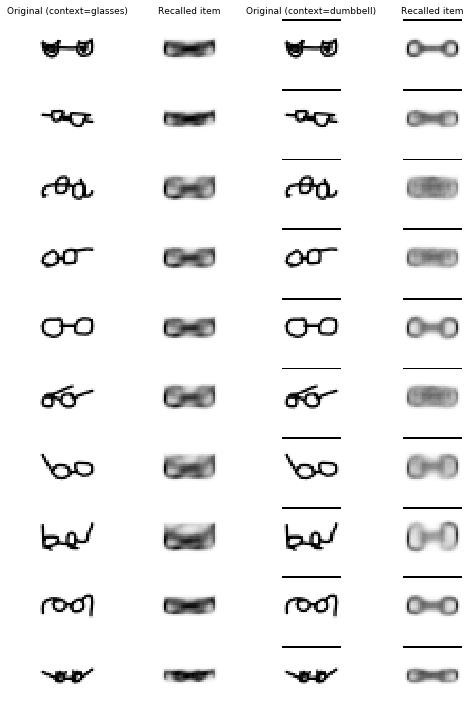

In [19]:
fig, axs = plt.subplots(10, 4, figsize=(7,10), sharex=True)

for i in range(10):
    item = glasses_without_cue[i]
    axs[i,0].imshow(np.resize(item, (28,28)), cmap='Greys')
    axs[i,0].axis('off')

    encoding = encoder.predict(item.reshape(1,28,28,1))
    x_decoded = decoder.predict(encoding)
    axs[i,1].imshow(np.resize(x_decoded, (28,28)), cmap='Greys')
    axs[i,1].axis('off')
    
    item = glasses_with_cue[i]
    axs[i,2].imshow(np.resize(item, (28,28)), cmap='Greys')
    axs[i,2].axis('off')
    
    encoding = encoder.predict(item.reshape(1,28,28,1))
    x_decoded = decoder.predict(encoding)
    axs[i,3].imshow(np.resize(x_decoded, (28,28)), cmap='Greys')
    axs[i,3].axis('off')
    
    
for ax, col in zip(axs[0,:], ['Original (context=glasses)', 
                              'Recalled item', 
                              'Original (context=dumbbell)', 
                              'Recalled item']):
    ax.set_title(col, size=9)
    
fig.tight_layout() 
plt.show()

#### How does context affect recall of ambiguous items from the dumbbells category?

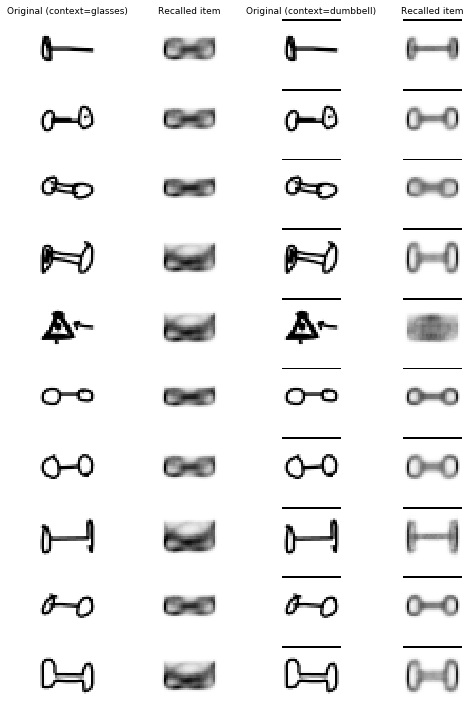

In [20]:
fig, axs = plt.subplots(10, 4, figsize=(7,10), sharex=True)

for i in range(10):
    item = dumbbells_without_cue[i]
    axs[i,0].imshow(np.resize(item, (28,28)), cmap='Greys')
    axs[i,0].axis('off')

    encoding = encoder.predict(item.reshape(1,28,28,1))
    x_decoded = decoder.predict(encoding)
    axs[i,1].imshow(np.resize(x_decoded, (28,28)), cmap='Greys')
    axs[i,1].axis('off')
    
    item = dumbbells_with_cue[i]
    axs[i,2].imshow(np.resize(item, (28,28)), cmap='Greys')
    axs[i,2].axis('off')
    
    encoding = encoder.predict(item.reshape(1,28,28,1))
    x_decoded = decoder.predict(encoding)
    axs[i,3].imshow(np.resize(x_decoded, (28,28)), cmap='Greys')
    axs[i,3].axis('off')
    
    
for ax, col in zip(axs[0,:], ['Original (context=glasses)', 
                              'Recalled item', 
                              'Original (context=dumbbell)', 
                              'Recalled item']):
    ax.set_title(col, size=9)
    
fig.tight_layout() 
plt.show()

Plotting the latent space (i.e. generating items for equally spaced points in the 2D latent space):

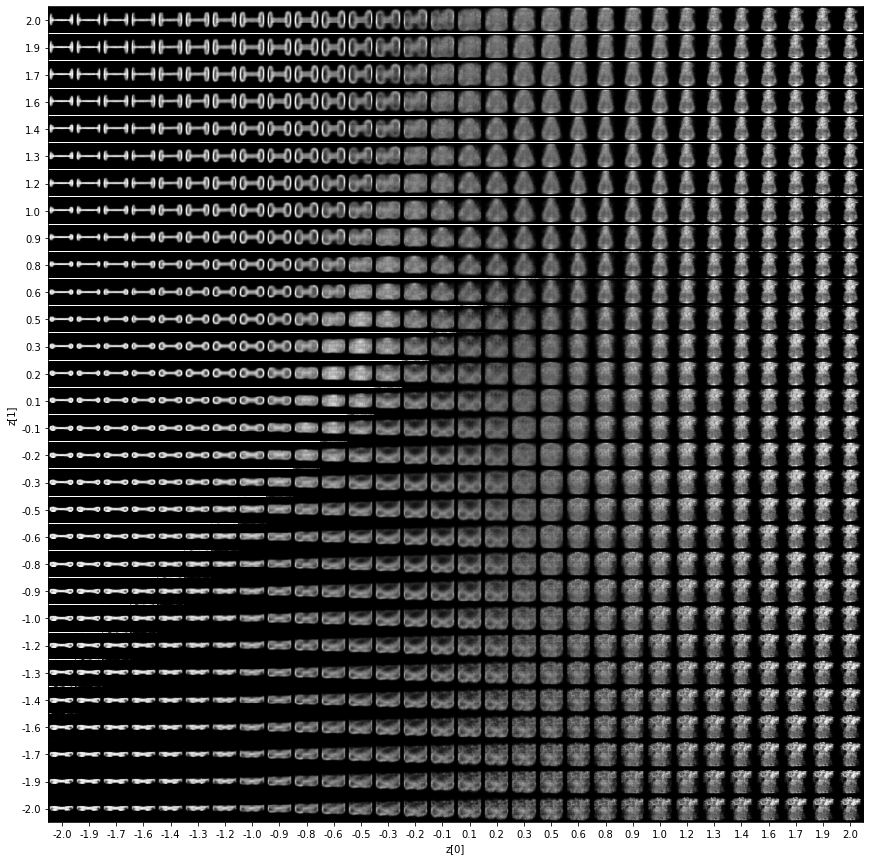

In [21]:
plot_latent(encoder, decoder)

#### Verify this works for the bat-butterfly model too:

In [44]:
resized_train = [np.resize(add_class_bar(d), (28,28,1)) for d in data3][0:num] + [np.resize(d, (28,28,1)) for d in data4][0:num]
train = np.stack(resized_train, axis=0).astype("float32") / 255

In [23]:
encoder, decoder = build_models(latent_dim=2)

In [29]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(train, epochs=30, batch_size=128, verbose=False)

In [30]:
bat_with_cue = [np.resize(add_class_bar(d), (28,28,1)) for d in data3[0:10]]
bat_with_cue = np.array(bat_with_cue).astype("float32") / 255
bat_without_cue = [np.resize(d, (28,28,1)) for d in data3[0:10]]
bat_without_cue = np.array(bat_without_cue).astype("float32") / 255

butterfly_with_cue = [np.resize(add_class_bar(d), (28,28,1)) for d in data4[0:10]]
butterfly_with_cue = np.array(butterfly_with_cue).astype("float32") / 255
butterfly_without_cue = [np.resize(d, (28,28,1)) for d in data4[0:10]]
butterfly_without_cue = np.array(butterfly_without_cue).astype("float32") / 255

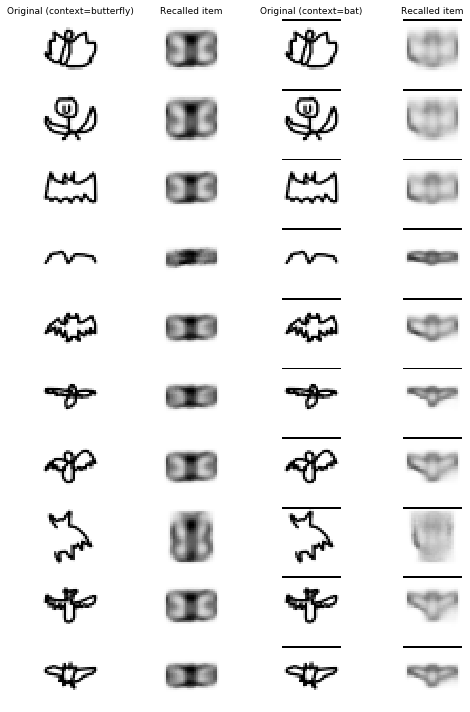

In [31]:
fig, axs = plt.subplots(10, 4, figsize=(7,10), sharex=True)

for i in range(10):
    item = bat_without_cue[i]
    axs[i,0].imshow(np.resize(item, (28,28)), cmap='Greys')
    axs[i,0].axis('off')

    encoding = encoder.predict(item.reshape(1,28,28,1))
    x_decoded = decoder.predict(encoding)
    axs[i,1].imshow(np.resize(x_decoded, (28,28)), cmap='Greys')
    axs[i,1].axis('off')
    
    item = bat_with_cue[i]
    axs[i,2].imshow(np.resize(item, (28,28)), cmap='Greys')
    axs[i,2].axis('off')
    
    encoding = encoder.predict(item.reshape(1,28,28,1))
    x_decoded = decoder.predict(encoding)
    axs[i,3].imshow(np.resize(x_decoded, (28,28)), cmap='Greys')
    axs[i,3].axis('off')
    
    
for ax, col in zip(axs[0,:], ['Original (context=butterfly)', 
                              'Recalled item', 
                              'Original (context=bat)', 
                              'Recalled item']):
    ax.set_title(col, size=9)
    
fig.tight_layout() 
plt.show()

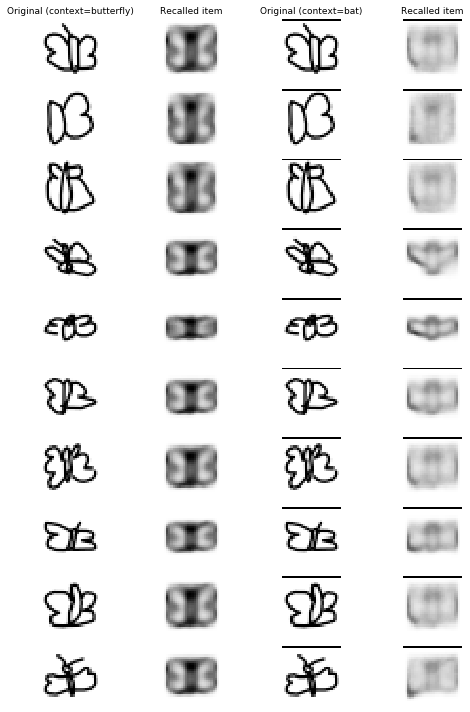

In [32]:
fig, axs = plt.subplots(10, 4, figsize=(7,10), sharex=True)

for i in range(10):
    item = butterfly_without_cue[i]
    axs[i,0].imshow(np.resize(item, (28,28)), cmap='Greys')
    axs[i,0].axis('off')

    encoding = encoder.predict(item.reshape(1,28,28,1))
    x_decoded = decoder.predict(encoding)
    axs[i,1].imshow(np.resize(x_decoded, (28,28)), cmap='Greys')
    axs[i,1].axis('off')
    
    item = butterfly_with_cue[i]
    axs[i,2].imshow(np.resize(item, (28,28)), cmap='Greys')
    axs[i,2].axis('off')
    
    encoding = encoder.predict(item.reshape(1,28,28,1))
    x_decoded = decoder.predict(encoding)
    axs[i,3].imshow(np.resize(x_decoded, (28,28)), cmap='Greys')
    axs[i,3].axis('off')
    
    
for ax, col in zip(axs[0,:], ['Original (context=butterfly)', 
                              'Recalled item', 
                              'Original (context=bat)', 
                              'Recalled item']):
    ax.set_title(col, size=9)
    
fig.tight_layout() 
plt.show()

Plotting the latent space (i.e. generating items for equally spaced points in the 2D latent space):

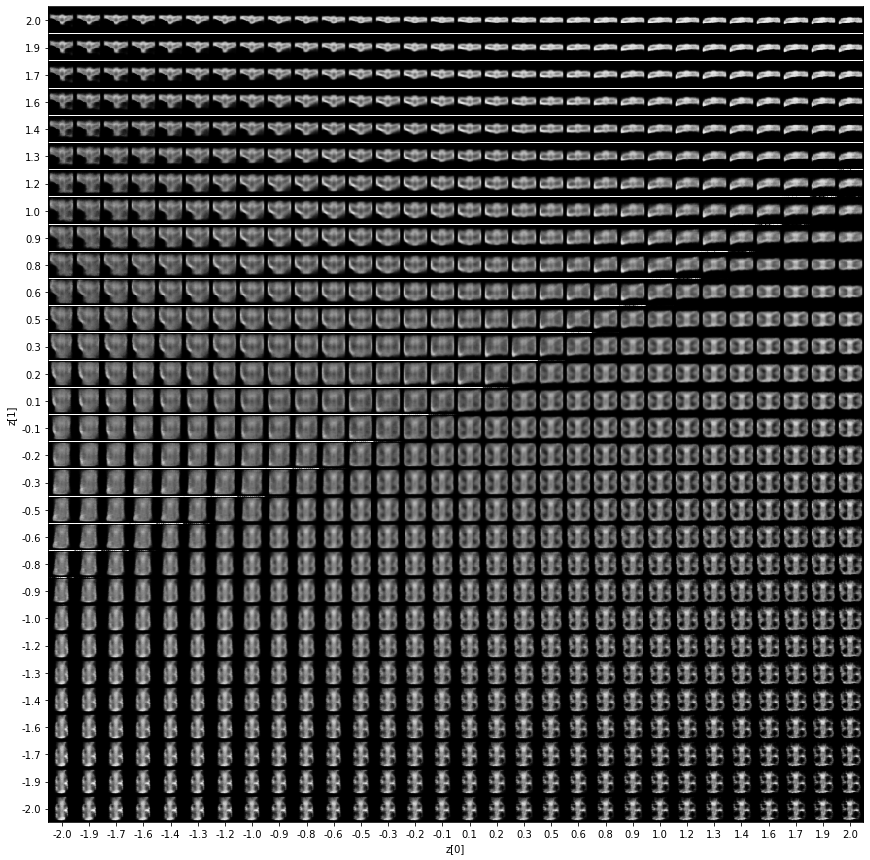

In [33]:
plot_latent(encoder, decoder)

### Other things of interest

#### Effect of the number of latent variables

Let's try building models with a different dimension latent space, and see how that effects these results. The following cells trains 4 models with 2, 4, 6, and 8 latent variables respectively.

In [117]:
import pickle

models = []
latent_dims = [2,4,6,8]

for l_d in latent_dims:
    print("Training model with {} latent variables.".format(l_d))
    encoder, decoder = build_models(latent_dim=l_d)
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(train, epochs=30, batch_size=128, verbose=False)
    
    models.append((encoder,decoder,vae))

Training model with 8 latent variables.


Let's see how the different models recall the same item.

It appears that smaller the dimension of the latent space, the greater the distortion (this makes sense as the memory gets compressed more). In other words, a variational autoencoder model of memory suggests you have more gist-based distortion when the storage capacity of the 'semantic memory' is smaller.

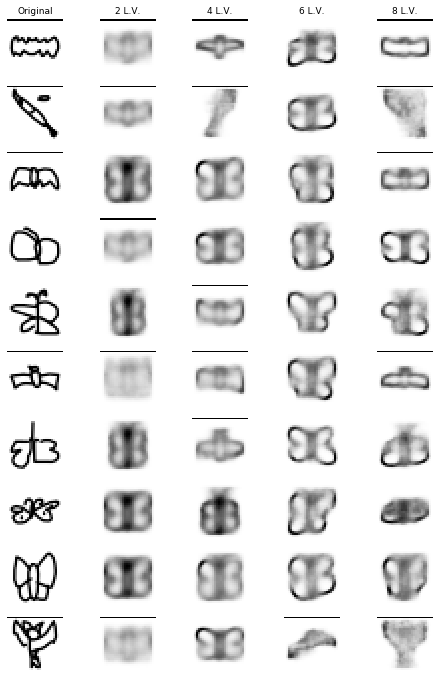

In [121]:
fig, axs = plt.subplots(10, 5, figsize=(8,12), sharex=True)

for ind, (encoder, decoder, vae) in enumerate(models):
    for i in range(10):
        item = train[random.randrange(0,len(train))]
        
        axs[i,0].imshow(np.resize(item, (28,28)), cmap='Greys')
        axs[i,0].axis('off')

        encoding = encoder.predict(item.reshape(1,28,28,1))
        x_decoded = decoder.predict(encoding)
        axs[i,ind+1].imshow(np.resize(x_decoded, (28,28)), cmap='Greys')
        axs[i,ind+1].axis('off')
        
for ax, col in zip(axs[0,:], ['Original', 
                              '2 L.V.', 
                              '4 L.V.', 
                              '6 L.V.',
                              '8 L.V.']):
    ax.set_title(col, size=9)
        
plt.show()

#### References

Carmichael, L., Hogan, H. P., & Walter, A. A. (1932). An experimental study of the effect of language on the reproduction of visually perceived form. Journal of experimental Psychology, 15(1), 73.

Nagy, D. G., Török, B., & Orbán, G. (2020). Optimal forgetting: Semantic compression of episodic memories. PLOS Computational Biology, 16(10), e1008367.